# Application demo: Calculate EIT ratio as a function of a scanned variable

In [1]:
from rydanalysis import AbsorptionImaging, OldStructure, ExpSequence, Gaussian2D, fit_dataarray
from rydanalysis import EllipticalMask, PolygonMask
from pathlib import Path
from lmfit import Parameter
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Sequence path date+folder
seq_path = Path('2020_02_12/EIT_resonancescan')
# mount directory of data server
data_root = Path('/media/david/data')
# local analysis root
analysis_root = Path('/home/david/Institut/analysis')
netcdf_suffix = '.h5'

In [3]:
try: (analysis_root/seq_path).mkdir()
except FileExistsError: pass

In [4]:
# check if raw_data file was already created locally and load or create
if (analysis_root/seq_path/'raw_data.h5').is_file():
    seq = ExpSequence(analysis_root/seq_path)
else:
    seq = OldStructure(data_root/seq_path)
    seq.save_raw_data(path=analysis_root/seq_path)
data = seq.raw_data

In [5]:
crop_mask = data.image_01.polygon_mask.get_mask(coord_vertices=[[-220,980],[150,980],[200,-1050],[-150,-1050]])
roi_mask =  data.image_01.elliptical_mask.get_mask(center_x=10,center_y=-25, width_x=1300, width_y=9000)

In [6]:
ai = AbsorptionImaging.from_raw_data(data, crop_mask=crop_mask.data, mask = roi_mask.data)

trans = ai.transmission

average_coord = 'dDDSred'

trans_averaged = trans.groupby(average_coord).mean('shot')
od = -np.log(trans_averaged)

/home/david/Downloads/.anaconda3/envs/lab/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/david/Downloads/.anaconda3/envs/lab/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Fit one image as an example to check initial conditions.

In [7]:
image = od[10]

In [8]:
model_twolvl = Gaussian2D(prefix='twolvl_')
params_twolvl = model_twolvl.make_params()
params_twolvl['twolvl_amp']=Parameter(value=0.8)
params_twolvl['twolvl_cen_x']=Parameter(value=0, min=-50, max = 50)
params_twolvl['twolvl_cen_y']=Parameter(value=-200, min=-300, max = -100)
params_twolvl['twolvl_sig_x']=Parameter(value=100, min=100, max = 400)
params_twolvl['twolvl_sig_y']=Parameter(value=100, min=40, max = 700)
params_twolvl['twolvl_offset']=Parameter(value=0, vary=False)

In [10]:
model_dip = Gaussian2D(prefix='eit_')
params_dip = model_dip.make_params()
params_dip['eit_amp']=Parameter(value=-0.8)
params_dip['eit_cen_x']=Parameter(value=0, min=-50, max = 50)
params_dip['eit_cen_y']=Parameter(value=-200, min=-250, max = -100)
params_dip['eit_sig_x']=Parameter(value=80, min=10, max = 100)
params_dip['eit_sig_y']=Parameter(value=80, min=10, max = 100)

In [11]:
model = model_twolvl + model_dip
params = params_twolvl + params_dip

/home/david/Downloads/.anaconda3/envs/lab/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/david/Downloads/.anaconda3/envs/lab/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/david/Downloads/.anaconda3/envs/lab/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/david/Downloads/.anaconda3/envs/lab/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/david/Down

(<Figure size 432x432 with 4 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

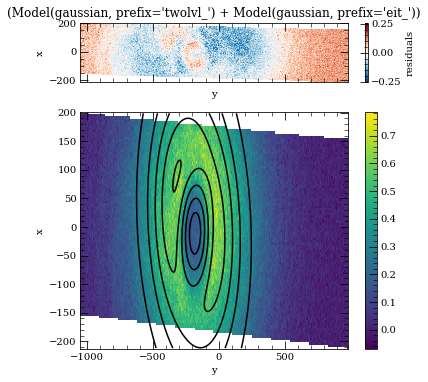

In [12]:
fit_result = model.fit(image, params)
# use results as new initial values
params = fit_result.params
fit_result.plot()

In [14]:
def calc_eit_ratio(params, model_twolvl, model_eit):
    params = params.to_parameters()
    x = [params['eit_cen_x'].value]
    y = [params['eit_cen_y'].value]
    # evaluate two level model at center of eit dip
    od_twolvl = model_twolvl.eval(params, x=x, y=y)
    # evaluate full model at center of eit dip
    od_eit = model.eval(params, x=x, y=y)
    ratio = od_eit/od_twolvl
    return ratio.squeeze(('x','y'))

Apply the fitter

In [15]:
res = od.groupby(average_coord).apply(fit_dataarray, args = (model, params))

Use results to calculate EIT

In [20]:
eit_ratio = res.groupby(average_coord).apply(calc_eit_ratio, args=(model_twolvl, model))
eit_ratio.name = 'EIT-ratio'

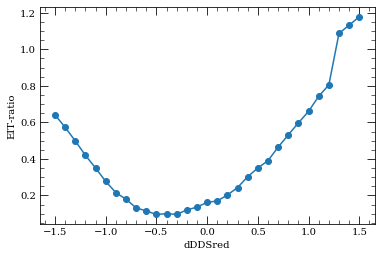

In [19]:
eit_ratio.plot(marker='o')